# Importations

## Installations des modules

In [0]:
!pip install -q keras

!pip install -q tqdm
from tqdm import tqdm

import random as rd
import numpy as np
import matplotlib.pyplot as plt
import os
!pip install -q panda
import pandas as pd
import tensorflow as tf
import timeit
from __future__ import print_function

In [2]:
#KERAS
import keras
from keras import activations, initializers, regularizers, constraints,metrics
from keras.legacy import interfaces
from keras.engine import InputSpec, Layer
from keras.layers import Input, BatchNormalization, concatenate, Reshape, Conv2DTranspose, Activation
from keras.layers.core import Reshape, Dense, Dropout, Flatten
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import Conv2D, UpSampling2D, MaxPooling2D
from keras.models import Model, Sequential
from keras.datasets import mnist
from keras.optimizers import Adam, Adagrad
from keras import backend as K
K.set_image_dim_ordering('tf')
from keras.utils import np_utils
from keras.utils.generic_utils import func_dump, func_load, deserialize_keras_object


Using TensorFlow backend.


In [192]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print('GPU device not found')
else:
  print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


## Base de données

In [4]:
from keras.datasets import mnist
# input image dimensions
img_rows, img_cols = 28, 28
nb_classes =10

##### Chargement des donnees

# the data, shuffled and split between train and test sets
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()

print (K.image_dim_ordering())

if K.image_dim_ordering() == 'th':
    X_train = X_train.reshape(X_train.shape[0], 1, img_rows, img_cols)
    X_test = X_test.reshape(X_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
    X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)


X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255
print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
y_train = np_utils.to_categorical(Y_train, nb_classes)
y_test = np_utils.to_categorical(Y_test, nb_classes)
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)

11493376/11490434 [==============================] - 3s 0us/step
tf
X_train shape: (60000, 28, 28, 1)
X_test shape: (10000, 28, 28, 1)
60000 train samples
10000 test samples
y_train shape: (60000, 10)
y_test shape: (10000, 10)


# Modèles

In [0]:
#Constantes

randomVectorSize = 50

adagrad_1 = Adagrad(lr=0.001, epsilon=None, decay=0.0)
adagrad_2 = Adagrad(lr=0.001, epsilon=None, decay=0.0)
adam_1 = Adam(lr=0.002, beta_1=0.5) #generateur GMV
adam_2 = Adam(lr=0.00005, beta_1=0.5) #discriminateur GMV

adam_3 = Adam(lr=0.00005, beta_1=0.5) #CGMV


## Generative MultiView Model (GMV)

In [264]:
#Choix du generateur et du discriminateur :
#generateur 1 et discriminateur 1 : les memes que pour le projet S8
#generateur 2 et discriminateur 2 : de l'article
generator_GMV = generator2_GMV
discriminator_GMV = discriminator2_GMV

#GAN
discriminator_GMV.trainable = False
gan_input_c = Input(shape=(randomVectorSize,))
gan_input_v1 = Input(shape=(randomVectorSize,))
gan_input_v2 = Input(shape=(randomVectorSize,))
x = generator_GMV ([gan_input_c, gan_input_v1])
y = generator_GMV ([gan_input_c, gan_input_v2])
gan_prediction = discriminator_GMV ([x, y])

gan_GMV = Model(input = [gan_input_c, gan_input_v1, gan_input_v2], output = gan_prediction)
gan_GMV.compile(optimizer=adam_1, loss='binary_crossentropy')
gan_GMV.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_55 (InputLayer)           (None, 50)           0                                            
__________________________________________________________________________________________________
input_56 (InputLayer)           (None, 50)           0                                            
__________________________________________________________________________________________________
input_57 (InputLayer)           (None, 50)           0                                            
__________________________________________________________________________________________________
model_95 (Model)                (None, 28, 28, 1)    3461121     input_55[0][0]                   
                                                                 input_56[0][0]                   
          

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("mo...)`
  del sys.path[0]


In [223]:
# Generator 1 

g_input_c = Input(shape=(randomVectorSize,),name="g_input_c")
g_input_v = Input(shape=(randomVectorSize,),name="g_input_v")
x = concatenate([g_input_c,g_input_v])
x = Dense(7*7*128, kernel_initializer=initializers.RandomNormal(stddev=0.02))(x)
x = LeakyReLU(0.2)                                                             (x)
x = Reshape((7,7,128))                                                         (x)
x = UpSampling2D(size=(2, 2))                                                  (x)
x = Conv2D(64, kernel_size=(5, 5), padding='same')                             (x)
x = LeakyReLU(0.2)                                                             (x)
x = UpSampling2D(size=(2, 2))                                                  (x)
g_prediction = Conv2D(1, kernel_size=(5, 5), padding='same', activation='tanh')(x)

generator1_GMV = Model(input = [g_input_c,g_input_v], output = g_prediction)
generator1_GMV.compile(optimizer='SGD', loss='binary_crossentropy')
generator1_GMV.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
g_input_c (InputLayer)          (None, 50)           0                                            
__________________________________________________________________________________________________
g_input_v (InputLayer)          (None, 50)           0                                            
__________________________________________________________________________________________________
concatenate_48 (Concatenate)    (None, 100)          0           g_input_c[0][0]                  
                                                                 g_input_v[0][0]                  
__________________________________________________________________________________________________
dense_25 (Dense)                (None, 6272)         633472      concatenate_48[0][0]             
__________

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("co...)`
  


In [275]:
# Generator 2
#New

g_input_c = Input(shape=(randomVectorSize,),name="g_input_c")
g_input_v = Input(shape=(randomVectorSize,),name="g_input_v")
x = concatenate([g_input_c,g_input_v])
x = Dense(4*4*512) (x)
x = Reshape((4,4,512)) (x)
x = Conv2DTranspose(256,kernel_size=(4,4),strides=(2,2), padding='same', kernel_initializer=initializers.RandomNormal(stddev=0.02)) (x)
x = BatchNormalization() (x)
x = Activation('relu') (x)
x = Conv2DTranspose(128,kernel_size=(4,4), strides=(2,2), padding='same', kernel_initializer=initializers.RandomNormal(stddev=0.02)) (x)
x = BatchNormalization() (x)
x = Activation('relu') (x)
#x = keras.layers.ZeroPadding2D(padding=(2, 2)) (x)
x = Conv2DTranspose(1,kernel_size=(13,13), strides=(1,1), padding='valid', kernel_initializer=initializers.RandomNormal(stddev=0.02)) (x)
g_prediction = Activation('tanh') (x)

generator2_GMV = Model(input = [g_input_c,g_input_v], output = g_prediction)
generator2_GMV.compile(optimizer=adam_1, loss='binary_crossentropy')
generator2_GMV.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
g_input_c (InputLayer)          (None, 50)           0                                            
__________________________________________________________________________________________________
g_input_v (InputLayer)          (None, 50)           0                                            
__________________________________________________________________________________________________
concatenate_79 (Concatenate)    (None, 100)          0           g_input_c[0][0]                  
                                                                 g_input_v[0][0]                  
__________________________________________________________________________________________________
dense_49 (Dense)                (None, 8192)         827392      concatenate_79[0][0]             
__________

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("ac...)`


In [261]:
# Discriminator 1

d_input_1 = Input(shape=(28,28,1),name="d_input_1")
d_input_2 = Input(shape=(28,28,1),name="d_input_2")
x = concatenate([d_input_1, d_input_2])
x = Reshape((28,28,2)) (x)
x = Conv2D(64, kernel_size=(4, 4), strides=(2, 2), padding='same', kernel_initializer=initializers.RandomNormal(stddev=0.02)) (x)
x = LeakyReLU(0.2)                                                 (x)
x = Dropout(0.3)                                                   (x)
x = Conv2D(128, kernel_size=(4, 4), strides=(2, 2), padding='same')(x)
x = LeakyReLU(0.2)                                                 (x)
x = Dropout(0.3)                                                   (x)
x = Flatten()                                                      (x)
d_prediction = Dense(1, activation='sigmoid', name='d_output')     (x)

discriminator1_GMV = Model(input = [d_input_1,d_input_2], output = d_prediction)
discriminator1_GMV.compile(optimizer='SGD', loss='binary_crossentropy')
discriminator1_GMV.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
d_input_1 (InputLayer)          (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
d_input_2 (InputLayer)          (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
concatenate_73 (Concatenate)    (None, 28, 28, 2)    0           d_input_1[0][0]                  
                                                                 d_input_2[0][0]                  
__________________________________________________________________________________________________
reshape_73 (Reshape)            (None, 28, 28, 2)    0           concatenate_73[0][0]             
__________

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("d_...)`
  from ipykernel import kernelapp as app


In [276]:
# Discriminator 2

d_input_1 = Input(shape=(28,28,1),name="d_input_1")
d_input_2 = Input(shape=(28,28,1),name="d_input_2")
x = concatenate([d_input_1, d_input_2])
x = Reshape((28,28,2)) (x)
x = Conv2D(64, kernel_size=(4, 4), strides=(2, 2), padding='same', kernel_initializer=initializers.RandomNormal(stddev=0.02)) (x)
x = LeakyReLU(0.2)                                                 (x)
#x = Dropout(0.3)                                                   (x)
x = Conv2D(128, kernel_size=(4, 4), strides=(2, 2), padding='same')(x)
x = BatchNormalization()                                           (x)
x = LeakyReLU(0.2)                                                 (x)
x = Conv2D(256, kernel_size=(4, 4), strides=(2, 2), padding='same')(x)
x = BatchNormalization()                                           (x)
x = LeakyReLU(0.2)                                                 (x)
#x = Dropout(0.3)                                                   (x)
x = Flatten()                                                      (x)
d_prediction = Dense(1, activation='sigmoid', name='d_output')     (x)

discriminator2_GMV = Model(input = [d_input_1,d_input_2], output = d_prediction)
discriminator2_GMV.compile(optimizer=adam_2, loss='binary_crossentropy')
discriminator2_GMV.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
d_input_1 (InputLayer)          (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
d_input_2 (InputLayer)          (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
concatenate_80 (Concatenate)    (None, 28, 28, 2)    0           d_input_1[0][0]                  
                                                                 d_input_2[0][0]                  
__________________________________________________________________________________________________
reshape_80 (Reshape)            (None, 28, 28, 2)    0           concatenate_80[0][0]             
__________

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("d_...)`


## Conditional Generative MultiView Model (CGMV)

In [282]:
# Generator

g_input_c = Input(shape=(randomVectorSize,),name="g_input_c")
g_input_v = Input(shape=(randomVectorSize,),name="g_input_v")
x = concatenate([g_input_c,g_input_v])
x = Dense(4*4*512) (x)
x = Reshape((4,4,512)) (x)
x = Conv2DTranspose(256,kernel_size=(4,4),strides=(2,2), padding='same', kernel_initializer=initializers.RandomNormal(stddev=0.02)) (x)
x = BatchNormalization() (x)
x = Activation('relu') (x)
x = Conv2DTranspose(128,kernel_size=(4,4), strides=(2,2), padding='same', kernel_initializer=initializers.RandomNormal(stddev=0.02)) (x)
x = BatchNormalization() (x)
x = Activation('relu') (x)
#x = keras.layers.ZeroPadding2D(padding=(2, 2)) (x)
x = Conv2DTranspose(1,kernel_size=(13,13), strides=(1,1), padding='valid', kernel_initializer=initializers.RandomNormal(stddev=0.02)) (x)
g_prediction = Activation('tanh') (x)

generator_CGMV = Model(input = [g_input_c,g_input_v], output = g_prediction)
generator_CGMV.compile(optimizer=adam_3, loss='binary_crossentropy')
generator_CGMV.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
g_input_c (InputLayer)          (None, 50)           0                                            
__________________________________________________________________________________________________
g_input_v (InputLayer)          (None, 50)           0                                            
__________________________________________________________________________________________________
concatenate_81 (Concatenate)    (None, 100)          0           g_input_c[0][0]                  
                                                                 g_input_v[0][0]                  
__________________________________________________________________________________________________
dense_50 (Dense)                (None, 8192)         827392      concatenate_81[0][0]             
__________

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("ac...)`


In [283]:
# Discriminator

d_input_1 = Input(shape=(28,28,1),name="d_input_1")
d_input_2 = Input(shape=(28,28,1),name="d_input_2")
x = concatenate([d_input_1, d_input_2])
x = Reshape((28,28,2)) (x)
x = Conv2D(64, kernel_size=(4, 4), strides=(2, 2), padding='same', kernel_initializer=initializers.RandomNormal(stddev=0.02)) (x)
x = LeakyReLU(0.2)                                                 (x)
#x = Dropout(0.3)                                                   (x)
x = Conv2D(128, kernel_size=(4, 4), strides=(2, 2), padding='same')(x)
x = BatchNormalization()                                           (x)
x = LeakyReLU(0.2)                                                 (x)
x = Conv2D(256, kernel_size=(4, 4), strides=(2, 2), padding='same')(x)
x = BatchNormalization()                                           (x)
x = LeakyReLU(0.2)                                                 (x)
#x = Dropout(0.3)                                                   (x)
x = Flatten()                                                      (x)
d_prediction = Dense(1, activation='sigmoid', name='d_output')     (x)

discriminator_CGMV = Model(input = [d_input_1,d_input_2], output = d_prediction)
discriminator_CGMV.compile(optimizer=adam_3, loss='binary_crossentropy')
discriminator_CGMV.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
d_input_1 (InputLayer)          (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
d_input_2 (InputLayer)          (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
concatenate_82 (Concatenate)    (None, 28, 28, 2)    0           d_input_1[0][0]                  
                                                                 d_input_2[0][0]                  
__________________________________________________________________________________________________
reshape_82 (Reshape)            (None, 28, 28, 2)    0           concatenate_82[0][0]             
__________

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("d_...)`


In [284]:
#Encodeur

e_input = Input(shape=(28,28,1),name="e_input")
x = Conv2D(64, kernel_size=(4, 4), strides=(2, 2), padding='same', kernel_initializer=initializers.RandomNormal(stddev=0.02)) (e_input)
x = LeakyReLU(0.2)                                                 (x)
#x = Dropout(0.3)                                                   (x)
x = Conv2D(128, kernel_size=(4, 4), strides=(2, 2), padding='same')(x)
x = BatchNormalization()                                           (x)
x = LeakyReLU(0.2)                                                 (x)
x = Conv2D(256, kernel_size=(4, 4), strides=(2, 2), padding='same')(x)
x = BatchNormalization()                                           (x)
x = LeakyReLU(0.2)                                                 (x)
#x = Dropout(0.3)                                                   (x)
x = Flatten()                                                      (x)
e_prediction = Dense(randomVectorSize, activation='sigmoid', name='e_output')     (x)

encodeur_CGMV = Model(input = e_input, output = e_prediction)
encodeur_CGMV.compile(optimizer=adam_3, loss='binary_crossentropy')
encodeur_CGMV.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
e_input (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_101 (Conv2D)          (None, 14, 14, 64)        1088      
_________________________________________________________________
leaky_re_lu_90 (LeakyReLU)   (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_102 (Conv2D)          (None, 7, 7, 128)         131200    
_________________________________________________________________
batch_normalization_145 (Bat (None, 7, 7, 128)         512       
_________________________________________________________________
leaky_re_lu_91 (LeakyReLU)   (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_103 (Conv2D)          (None, 4, 4, 256)         524544    
__________

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("e_..., outputs=Tensor("e_...)`
  app.launch_new_instance()


In [0]:
#GAN CGMV (Encodeur -> Generateur -> Discriminateur)

discriminator_CGMV.trainable = False

gan_input_x1 = Input(shape=(randomVectorSize,)) #image qui est utilisee deux fois par le generateur
gan_input_x2 = Input(shape=(randomVectorSize,)) #image dont une autre vue sera generee
gan_input_v1 = Input(shape=(randomVectorSize,))
gan_input_v2 = Input(shape=(randomVectorSize,))
gan_input_v3 = Input(shape=(randomVectorSize,))

c1 = encodeur_CGMV(gan_input_x1)
c2 = encodeur_CGMV(gan_input_x2)

x = generator_CGMV ([c1, gan_input_v1])
y = generator_CGMV ([c1, gan_input_v2])
z = generator_CGMV ([c2, gan_input_v3])

gan_prediction_1 = discriminator_CGMV ([x, y])
gan_prediction_2 = discriminator_CGMV ([gan_input_x2, z])

gan_CGMV = Model(input = [gan_input_x1, gan_input_x2, gan_input_v1, gan_input_v2, gan_input_v3], output = [gan_prediction_1, gan_prediction_2])
gan_CGMV.compile(optimizer=adam_3, loss='binary_crossentropy')
gan_CGMV.summary()

# Entraînements

## Mise en forme des données

In [10]:
#Pour l'entrainement

#nombre de couples d'images utilisés pour entraîner le GAN
nb_train=20000
nb_train_par_classe=int(nb_train/nb_classes)

#separation des images par classes
X_0=X_train[np.where(Y_train==0)]
X_1=X_train[np.where(Y_train==1)]
X_2=X_train[np.where(Y_train==2)]
X_3=X_train[np.where(Y_train==3)]
X_4=X_train[np.where(Y_train==4)]
X_5=X_train[np.where(Y_train==5)]
X_6=X_train[np.where(Y_train==6)]
X_7=X_train[np.where(Y_train==7)]
X_8=X_train[np.where(Y_train==8)]
X_9=X_train[np.where(Y_train==9)]
X=[X_0,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,X_9]

X_train_2=np.zeros((nb_train_par_classe*10,2,28,28,1))

#creation des couples d'images
for i in range(nb_train_par_classe):
  for j in range(10):
    k1=rd.randint(0,len(X[j])-1)
    k2=rd.randint(0,len(X[j])-1)
    while k1==k2:
      k2=rd.randint(0,len(X[j])-1)
    img1=X[j][k1]
    img2=X[j][k2]
    X_train_2[10*i+j][0]=img1
    X_train_2[10*i+j][1]=img2
  
np.random.shuffle(X_train_2)
print("X_train_2.shape = ", X_train_2.shape)

#Pour le test

#nombre de couples d'images utilisés pour tester le GAN
nb_test=20000
nb_test_par_classe=int(nb_test/nb_classes)

#separation des images par classes
Xt_0=X_test[np.where(Y_test==0)]
Xt_1=X_test[np.where(Y_test==1)]
Xt_2=X_test[np.where(Y_test==2)]
Xt_3=X_test[np.where(Y_test==3)]
Xt_4=X_test[np.where(Y_test==4)]
Xt_5=X_test[np.where(Y_test==5)]
Xt_6=X_test[np.where(Y_test==6)]
Xt_7=X_test[np.where(Y_test==7)]
Xt_8=X_test[np.where(Y_test==8)]
Xt_9=X_test[np.where(Y_test==9)]
Xt=[Xt_0,Xt_1,Xt_2,Xt_3,Xt_4,Xt_5,Xt_6,Xt_7,Xt_8,Xt_9]

X_test_2=np.zeros((nb_test_par_classe*10,2,28,28,1))

#creation des couples d'images
for i in range(nb_test_par_classe):
  for j in range(10):
    k1=rd.randint(0,len(Xt[j])-1)
    k2=rd.randint(0,len(Xt[j])-1)
    while k1==k2:
      k2=rd.randint(0,len(Xt[j])-1)
    img1=Xt[j][k1]
    img2=Xt[j][k2]
    X_test_2[10*i+j][0]=img1
    X_test_2[10*i+j][1]=img2
  
np.random.shuffle(X_test_2)
print("X_test_2.shape = ", X_test_2.shape)

X_train_2.shape =  (20000, 2, 28, 28, 1)
X_test_2.shape =  (20000, 2, 28, 28, 1)


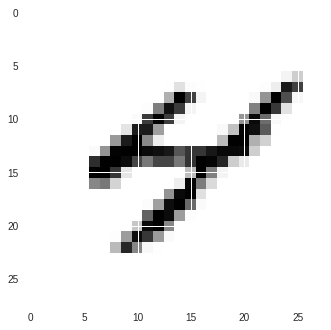

In [128]:
IMG=[]
for a in range(5):
  IMG.append(np.reshape(X_train_2[a][0],(28,28)))
  IMG.append(np.reshape(X_train_2[a][1],(28,28)))
plt.imshow(IMG[2])


## Entraînement GMV

In [281]:
def train_GMV(generator, discriminator, gan, X_train_2, epochs=100, batchSize=128):
  batchCount = int(nb_train_par_classe*10 / batchSize)
  print ('Epochs:', epochs)
  print ('Batch size:', batchSize)
  print ('Batches per epoch:', batchCount)
  d_losses = []
  g_losses = []
  for e in range(1, epochs+1):
    print ('-'*15, 'Epoch %d' % e, '-'*15)
    dloss=0
    gloss=0
    for _ in tqdm(range(batchCount)):
      # DISCRIMINATOR
      #generation des vecteurs de bruit
      vector_c = np.random.normal(0, 1, size=[batchSize, randomVectorSize])
      vector_v1 = np.random.normal(0, 1, size=[batchSize, randomVectorSize])
      vector_v2 = np.random.normal(0, 1, size=[batchSize, randomVectorSize])
      
      #passage dans le generateur
      generatedImages_1 = generator.predict([vector_c,vector_v1])
      generatedImages_2 = generator.predict([vector_c,vector_v2])
      
      #entraînement du discriminateur
      indices=np.random.randint(0, nb_train_par_classe*10, size=batchSize)
      imageBatch_1 = np.zeros((len(indices),28,28,1))
      imageBatch_2 = np.zeros((len(indices),28,28,1))
      for i in range(len(indices)):
        imageBatch_1[i]=X_train_2[indices[i]][0]
        imageBatch_2[i]=X_train_2[indices[i]][1]
      XDis1=np.concatenate((imageBatch_1,generatedImages_1))
      XDis2=np.concatenate((imageBatch_2,generatedImages_2))
      yDis = np.zeros(2*batchSize)
      yDis[:batchSize] = 0.9
      yDis[:batchSize]=0.1
      dloss += discriminator.train_on_batch([XDis1,XDis2], yDis)

      # GENERATOR
      vector_c = np.random.normal(0, 1, size=[batchSize, randomVectorSize])
      vector_v1 = np.random.normal(0, 1, size=[batchSize, randomVectorSize])
      vector_v2 = np.random.normal(0, 1, size=[batchSize, randomVectorSize])
      yGen = np.ones(batchSize)
      discriminator.trainable = False
      gloss += gan.train_on_batch([vector_c,vector_v1,vector_v2], yGen)
      
    # TESTS ET EVALUATIONS
    d_losses.append(dloss)
    g_losses.append(gloss)
    print ("Losses : DISCRIMINATOR ", d_losses[-1]," GENERATOR ", g_losses[-1])
  return(d_losses,g_losses)


d_losses,g_losses=train_GMV(generator_GMV,discriminator_GMV,gan_GMV,X_train_2,5,128)    







  0%|          | 0/156 [00:00<?, ?it/s]

Epochs: 5
Batch size: 128
Batches per epoch: 156
--------------- Epoch 1 ---------------


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:975: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'






  1%|          | 1/156 [00:04<11:54,  4.61s/it]





  1%|▏         | 2/156 [00:04<06:21,  2.48s/it]





  2%|▏         | 3/156 [00:05<04:29,  1.76s/it]





  3%|▎         | 4/156 [00:05<03:33,  1.40s/it]





  3%|▎         | 5/156 [00:05<02:59,  1.19s/it]





  4%|▍         | 6/156 [00:06<02:36,  1.05s/it]





  4%|▍         | 7/156 [00:06<02:20,  1.06it/s]





  5%|▌         | 8/156 [00:06<02:08,  1.15it/s]





  6%|▌         | 9/156 [00:07<01:58,  1.24it/s]





  6%|▋         | 10/156 [00:07<01:50,  1.32it/s]





  7%|▋         | 11/156 [00:07<01:44,  1.39it/s]





  8%|▊         | 12/156 [00:08<01:39,  1.45it/s]





  8%|▊         | 13/156 [00:08<01:34,  1.51it/s]





  9%|▉      

 17%|█▋        | 27/156 [00:13<01:03,  2.04it/s]





 18%|█▊        | 28/156 [00:13<01:01,  2.07it/s]





 19%|█▊        | 29/156 [00:13<01:00,  2.09it/s]





 19%|█▉        | 30/156 [00:14<00:59,  2.11it/s]





 20%|█▉        | 31/156 [00:14<00:58,  2.13it/s]





 21%|██        | 32/156 [00:14<00:57,  2.15it/s]





 21%|██        | 33/156 [00:15<00:56,  2.17it/s]





 22%|██▏       | 34/156 [00:15<00:55,  2.19it/s]





 22%|██▏       | 35/156 [00:15<00:54,  2.21it/s]





 23%|██▎       | 36/156 [00:16<00:54,  2.22it/s]





 24%|██▎       | 37/156 [00:16<00:53,  2.24it/s]





 24%|██▍       | 38/156 [00:16<00:52,  2.25it/s]





 25%|██▌       | 39/156 [00:17<00:51,  2.27it/s]





 26%|██▌       | 40/156 [00:17<00:50,  2.28it/s]





 26%|██▋       | 41/156 [00:17<00:50,  2.30it/s]





 27%|██▋       | 42/156 [00:18<00:49,  2.31it/s]





 28%|██▊       | 43/156 [00:18<00:48,  2.32it/s]





 28%|██▊       | 44/156 [00:18<00:47,  2.33it/s]





 29%|██▉       | 45/156 [00:

 37%|███▋      | 57/156 [00:23<00:40,  2.46it/s]





 37%|███▋      | 58/156 [00:23<00:39,  2.47it/s]





 38%|███▊      | 59/156 [00:23<00:39,  2.48it/s]





 38%|███▊      | 60/156 [00:24<00:38,  2.49it/s]





 39%|███▉      | 61/156 [00:24<00:38,  2.49it/s]





 40%|███▉      | 62/156 [00:24<00:37,  2.50it/s]





 40%|████      | 63/156 [00:25<00:37,  2.51it/s]





 41%|████      | 64/156 [00:25<00:36,  2.51it/s]





 42%|████▏     | 65/156 [00:25<00:36,  2.52it/s]





 42%|████▏     | 66/156 [00:26<00:35,  2.53it/s]





 43%|████▎     | 67/156 [00:26<00:35,  2.53it/s]





 44%|████▎     | 68/156 [00:26<00:34,  2.54it/s]





 44%|████▍     | 69/156 [00:27<00:34,  2.55it/s]





 45%|████▍     | 70/156 [00:27<00:33,  2.55it/s]





 46%|████▌     | 71/156 [00:27<00:33,  2.56it/s]





 46%|████▌     | 72/156 [00:28<00:32,  2.57it/s]





 47%|████▋     | 73/156 [00:28<00:32,  2.57it/s]





 47%|████▋     | 74/156 [00:28<00:31,  2.58it/s]





 48%|████▊     | 75/156 [00:

 56%|█████▌    | 87/156 [00:33<00:26,  2.63it/s]





 56%|█████▋    | 88/156 [00:33<00:25,  2.64it/s]





 57%|█████▋    | 89/156 [00:33<00:25,  2.64it/s]





 58%|█████▊    | 90/156 [00:34<00:24,  2.65it/s]





 58%|█████▊    | 91/156 [00:34<00:24,  2.65it/s]





 59%|█████▉    | 92/156 [00:34<00:24,  2.65it/s]





 60%|█████▉    | 93/156 [00:35<00:23,  2.66it/s]





 60%|██████    | 94/156 [00:35<00:23,  2.66it/s]





 61%|██████    | 95/156 [00:35<00:22,  2.66it/s]





 62%|██████▏   | 96/156 [00:35<00:22,  2.67it/s]





 62%|██████▏   | 97/156 [00:36<00:22,  2.67it/s]





 63%|██████▎   | 98/156 [00:36<00:21,  2.67it/s]





 63%|██████▎   | 99/156 [00:36<00:21,  2.68it/s]





 64%|██████▍   | 100/156 [00:37<00:20,  2.68it/s]





 65%|██████▍   | 101/156 [00:37<00:20,  2.68it/s]





 65%|██████▌   | 102/156 [00:37<00:20,  2.69it/s]





 66%|██████▌   | 103/156 [00:38<00:19,  2.69it/s]





 67%|██████▋   | 104/156 [00:38<00:19,  2.69it/s]





 67%|██████▋   | 105/15







 75%|███████▌  | 117/156 [00:42<00:14,  2.73it/s]





 76%|███████▌  | 118/156 [00:43<00:13,  2.73it/s]





 76%|███████▋  | 119/156 [00:43<00:13,  2.73it/s]





 77%|███████▋  | 120/156 [00:43<00:13,  2.73it/s]





 78%|███████▊  | 121/156 [00:44<00:12,  2.74it/s]





 78%|███████▊  | 122/156 [00:44<00:12,  2.74it/s]





 79%|███████▉  | 123/156 [00:44<00:12,  2.74it/s]





 79%|███████▉  | 124/156 [00:45<00:11,  2.74it/s]





 80%|████████  | 125/156 [00:45<00:11,  2.74it/s]





 81%|████████  | 126/156 [00:45<00:10,  2.75it/s]





 81%|████████▏ | 127/156 [00:46<00:10,  2.75it/s]





 82%|████████▏ | 128/156 [00:46<00:10,  2.75it/s]





 83%|████████▎ | 129/156 [00:46<00:09,  2.75it/s]





 83%|████████▎ | 130/156 [00:47<00:09,  2.75it/s]





 84%|████████▍ | 131/156 [00:47<00:09,  2.76it/s]





 85%|████████▍ | 132/156 [00:47<00:08,  2.76it/s]





 85%|████████▌ | 133/156 [00:48<00:08,  2.76it/s]





 86%|████████▌ | 134/156 [00:48<00:07,  2.76it/s]





 87%







 94%|█████████▍| 147/156 [00:52<00:03,  2.78it/s]





 95%|█████████▍| 148/156 [00:53<00:02,  2.79it/s]





 96%|█████████▌| 149/156 [00:53<00:02,  2.79it/s]





 96%|█████████▌| 150/156 [00:53<00:02,  2.79it/s]





 97%|█████████▋| 151/156 [00:54<00:01,  2.79it/s]





 97%|█████████▋| 152/156 [00:54<00:01,  2.79it/s]





 98%|█████████▊| 153/156 [00:54<00:01,  2.79it/s]





 99%|█████████▊| 154/156 [00:55<00:00,  2.80it/s]





 99%|█████████▉| 155/156 [00:55<00:00,  2.80it/s]





100%|██████████| 156/156 [00:55<00:00,  2.80it/s]











  0%|          | 0/156 [00:00<?, ?it/s]

Losses : DISCRIMINATOR  25.391491413116455  GENERATOR  52.46616181731224
--------------- Epoch 2 ---------------








  1%|          | 1/156 [00:00<00:49,  3.12it/s]





  1%|▏         | 2/156 [00:00<00:50,  3.04it/s]





  2%|▏         | 3/156 [00:00<00:50,  3.01it/s]





  3%|▎         | 4/156 [00:01<00:50,  3.03it/s]





  3%|▎         | 5/156 [00:01<00:50,  3.02it/s]





  4%|▍         | 6/156 [00:01<00:49,  3.02it/s]





  4%|▍         | 7/156 [00:02<00:49,  3.03it/s]





  5%|▌         | 8/156 [00:02<00:48,  3.03it/s]





  6%|▌         | 9/156 [00:02<00:48,  3.03it/s]





  6%|▋         | 10/156 [00:03<00:48,  3.03it/s]





  7%|▋         | 11/156 [00:03<00:47,  3.03it/s]





  8%|▊         | 12/156 [00:03<00:47,  3.03it/s]





  8%|▊         | 13/156 [00:04<00:47,  3.04it/s]





  9%|▉         | 14/156 [00:04<00:46,  3.04it/s]





 10%|▉         | 15/156 [00:04<00:46,  3.04it/s]





 10%|█         | 16/156 [00:05<00:46,  3.04it/s]





 11%|█         | 17/156 [00:05<00:45,  3.03it/s]





 12%|█▏        | 18/156 [00:05<00:45,  3.03it/s]





 12%|█▏        | 19/156 [00:06<

 20%|█▉        | 31/156 [00:10<00:41,  3.04it/s]





 21%|██        | 32/156 [00:10<00:40,  3.04it/s]





 21%|██        | 33/156 [00:10<00:40,  3.04it/s]





 22%|██▏       | 34/156 [00:11<00:40,  3.04it/s]





 22%|██▏       | 35/156 [00:11<00:39,  3.04it/s]





 23%|██▎       | 36/156 [00:11<00:39,  3.05it/s]





 24%|██▎       | 37/156 [00:12<00:39,  3.05it/s]





 24%|██▍       | 38/156 [00:12<00:38,  3.05it/s]





 25%|██▌       | 39/156 [00:12<00:38,  3.04it/s]





 26%|██▌       | 40/156 [00:13<00:38,  3.05it/s]





 26%|██▋       | 41/156 [00:13<00:37,  3.05it/s]





 27%|██▋       | 42/156 [00:13<00:37,  3.05it/s]





 28%|██▊       | 43/156 [00:14<00:37,  3.05it/s]





 28%|██▊       | 44/156 [00:14<00:36,  3.04it/s]





 29%|██▉       | 45/156 [00:14<00:36,  3.04it/s]





 29%|██▉       | 46/156 [00:15<00:36,  3.05it/s]





 30%|███       | 47/156 [00:15<00:35,  3.04it/s]





 31%|███       | 48/156 [00:15<00:35,  3.05it/s]





 31%|███▏      | 49/156 [00:

 39%|███▉      | 61/156 [00:20<00:31,  3.05it/s]





 40%|███▉      | 62/156 [00:20<00:30,  3.05it/s]





 40%|████      | 63/156 [00:20<00:30,  3.05it/s]





 41%|████      | 64/156 [00:21<00:30,  3.05it/s]





 42%|████▏     | 65/156 [00:21<00:29,  3.05it/s]





 42%|████▏     | 66/156 [00:21<00:29,  3.05it/s]





 43%|████▎     | 67/156 [00:21<00:29,  3.05it/s]





 44%|████▎     | 68/156 [00:22<00:28,  3.04it/s]





 44%|████▍     | 69/156 [00:22<00:28,  3.04it/s]





 45%|████▍     | 70/156 [00:22<00:28,  3.04it/s]





 46%|████▌     | 71/156 [00:23<00:27,  3.04it/s]





 46%|████▌     | 72/156 [00:23<00:27,  3.04it/s]





 47%|████▋     | 73/156 [00:23<00:27,  3.04it/s]





 47%|████▋     | 74/156 [00:24<00:26,  3.04it/s]





 48%|████▊     | 75/156 [00:24<00:26,  3.04it/s]





 49%|████▊     | 76/156 [00:24<00:26,  3.04it/s]





 49%|████▉     | 77/156 [00:25<00:25,  3.04it/s]





 50%|█████     | 78/156 [00:25<00:25,  3.04it/s]





 51%|█████     | 79/156 [00:

 58%|█████▊    | 91/156 [00:29<00:21,  3.05it/s]





 59%|█████▉    | 92/156 [00:30<00:21,  3.05it/s]





 60%|█████▉    | 93/156 [00:30<00:20,  3.05it/s]





 60%|██████    | 94/156 [00:30<00:20,  3.05it/s]





 61%|██████    | 95/156 [00:31<00:20,  3.05it/s]





 62%|██████▏   | 96/156 [00:31<00:19,  3.05it/s]





 62%|██████▏   | 97/156 [00:31<00:19,  3.05it/s]





 63%|██████▎   | 98/156 [00:32<00:19,  3.05it/s]





 63%|██████▎   | 99/156 [00:32<00:18,  3.05it/s]





 64%|██████▍   | 100/156 [00:32<00:18,  3.05it/s]





 65%|██████▍   | 101/156 [00:33<00:18,  3.05it/s]





 65%|██████▌   | 102/156 [00:33<00:17,  3.05it/s]





 66%|██████▌   | 103/156 [00:33<00:17,  3.05it/s]





 67%|██████▋   | 104/156 [00:34<00:17,  3.04it/s]





 67%|██████▋   | 105/156 [00:34<00:16,  3.04it/s]





 68%|██████▊   | 106/156 [00:34<00:16,  3.05it/s]





 69%|██████▊   | 107/156 [00:35<00:16,  3.05it/s]





 69%|██████▉   | 108/156 [00:35<00:15,  3.04it/s]





 70%|██████▉   | 10







 78%|███████▊  | 121/156 [00:39<00:11,  3.04it/s]





 78%|███████▊  | 122/156 [00:40<00:11,  3.04it/s]





 79%|███████▉  | 123/156 [00:40<00:10,  3.04it/s]





 79%|███████▉  | 124/156 [00:40<00:10,  3.04it/s]





 80%|████████  | 125/156 [00:41<00:10,  3.04it/s]





 81%|████████  | 126/156 [00:41<00:09,  3.04it/s]





 81%|████████▏ | 127/156 [00:41<00:09,  3.04it/s]





 82%|████████▏ | 128/156 [00:42<00:09,  3.04it/s]





 83%|████████▎ | 129/156 [00:42<00:08,  3.04it/s]





 83%|████████▎ | 130/156 [00:42<00:08,  3.04it/s]





 84%|████████▍ | 131/156 [00:43<00:08,  3.04it/s]





 85%|████████▍ | 132/156 [00:43<00:07,  3.04it/s]





 85%|████████▌ | 133/156 [00:43<00:07,  3.04it/s]





 86%|████████▌ | 134/156 [00:44<00:07,  3.04it/s]





 87%|████████▋ | 135/156 [00:44<00:06,  3.04it/s]





 87%|████████▋ | 136/156 [00:44<00:06,  3.04it/s]





 88%|████████▊ | 137/156 [00:45<00:06,  3.04it/s]





 88%|████████▊ | 138/156 [00:45<00:05,  3.04it/s]





 89%







 97%|█████████▋| 151/156 [00:49<00:01,  3.04it/s]





 97%|█████████▋| 152/156 [00:49<00:01,  3.04it/s]





 98%|█████████▊| 153/156 [00:50<00:00,  3.04it/s]





 99%|█████████▊| 154/156 [00:50<00:00,  3.04it/s]





 99%|█████████▉| 155/156 [00:50<00:00,  3.04it/s]





100%|██████████| 156/156 [00:51<00:00,  3.04it/s]











  0%|          | 0/156 [00:00<?, ?it/s]

Losses : DISCRIMINATOR  25.386796191334724  GENERATOR  46.851495906710625
--------------- Epoch 3 ---------------








  1%|          | 1/156 [00:00<00:48,  3.17it/s]





  1%|▏         | 2/156 [00:00<00:49,  3.13it/s]





  2%|▏         | 3/156 [00:00<00:49,  3.09it/s]





  3%|▎         | 4/156 [00:01<00:49,  3.06it/s]





  3%|▎         | 5/156 [00:01<00:49,  3.06it/s]





  4%|▍         | 6/156 [00:01<00:49,  3.05it/s]





  4%|▍         | 7/156 [00:02<00:48,  3.05it/s]





  5%|▌         | 8/156 [00:02<00:48,  3.05it/s]





  6%|▌         | 9/156 [00:02<00:48,  3.05it/s]





  6%|▋         | 10/156 [00:03<00:47,  3.05it/s]





  7%|▋         | 11/156 [00:03<00:47,  3.04it/s]





  8%|▊         | 12/156 [00:03<00:47,  3.04it/s]





  8%|▊         | 13/156 [00:04<00:47,  3.04it/s]





  9%|▉         | 14/156 [00:04<00:46,  3.04it/s]





 10%|▉         | 15/156 [00:04<00:46,  3.04it/s]





 10%|█         | 16/156 [00:05<00:46,  3.04it/s]





 11%|█         | 17/156 [00:05<00:45,  3.04it/s]





 12%|█▏        | 18/156 [00:05<00:45,  3.04it/s]





 12%|█▏        | 19/156 [00:06<

 20%|█▉        | 31/156 [00:10<00:41,  3.04it/s]





 21%|██        | 32/156 [00:10<00:40,  3.04it/s]





 21%|██        | 33/156 [00:10<00:40,  3.04it/s]





 22%|██▏       | 34/156 [00:11<00:40,  3.04it/s]





 22%|██▏       | 35/156 [00:11<00:39,  3.04it/s]





 23%|██▎       | 36/156 [00:11<00:39,  3.04it/s]





 24%|██▎       | 37/156 [00:12<00:39,  3.04it/s]





 24%|██▍       | 38/156 [00:12<00:38,  3.04it/s]





 25%|██▌       | 39/156 [00:12<00:38,  3.04it/s]





 26%|██▌       | 40/156 [00:13<00:38,  3.04it/s]





 26%|██▋       | 41/156 [00:13<00:37,  3.04it/s]





 27%|██▋       | 42/156 [00:13<00:37,  3.04it/s]





 28%|██▊       | 43/156 [00:14<00:37,  3.04it/s]





 28%|██▊       | 44/156 [00:14<00:36,  3.04it/s]





 29%|██▉       | 45/156 [00:14<00:36,  3.04it/s]





 29%|██▉       | 46/156 [00:15<00:36,  3.04it/s]





 30%|███       | 47/156 [00:15<00:35,  3.04it/s]





 31%|███       | 48/156 [00:15<00:35,  3.04it/s]





 31%|███▏      | 49/156 [00:

 39%|███▉      | 61/156 [00:20<00:31,  3.04it/s]





 40%|███▉      | 62/156 [00:20<00:30,  3.04it/s]





 40%|████      | 63/156 [00:20<00:30,  3.04it/s]





 41%|████      | 64/156 [00:21<00:30,  3.04it/s]





 42%|████▏     | 65/156 [00:21<00:29,  3.04it/s]





 42%|████▏     | 66/156 [00:21<00:29,  3.04it/s]





 43%|████▎     | 67/156 [00:22<00:29,  3.04it/s]





 44%|████▎     | 68/156 [00:22<00:28,  3.04it/s]





 44%|████▍     | 69/156 [00:22<00:28,  3.04it/s]





 45%|████▍     | 70/156 [00:23<00:28,  3.04it/s]





 46%|████▌     | 71/156 [00:23<00:27,  3.04it/s]





 46%|████▌     | 72/156 [00:23<00:27,  3.04it/s]





 47%|████▋     | 73/156 [00:24<00:27,  3.04it/s]





 47%|████▋     | 74/156 [00:24<00:26,  3.04it/s]





 48%|████▊     | 75/156 [00:24<00:26,  3.04it/s]





 49%|████▊     | 76/156 [00:25<00:26,  3.04it/s]





 49%|████▉     | 77/156 [00:25<00:25,  3.04it/s]





 50%|█████     | 78/156 [00:25<00:25,  3.04it/s]





 51%|█████     | 79/156 [00:

 58%|█████▊    | 91/156 [00:29<00:21,  3.04it/s]





 59%|█████▉    | 92/156 [00:30<00:21,  3.04it/s]





 60%|█████▉    | 93/156 [00:30<00:20,  3.04it/s]





 60%|██████    | 94/156 [00:30<00:20,  3.04it/s]





 61%|██████    | 95/156 [00:31<00:20,  3.04it/s]





 62%|██████▏   | 96/156 [00:31<00:19,  3.04it/s]





 62%|██████▏   | 97/156 [00:31<00:19,  3.04it/s]





 63%|██████▎   | 98/156 [00:32<00:19,  3.04it/s]





 63%|██████▎   | 99/156 [00:32<00:18,  3.04it/s]





 64%|██████▍   | 100/156 [00:32<00:18,  3.04it/s]





 65%|██████▍   | 101/156 [00:33<00:18,  3.04it/s]





 65%|██████▌   | 102/156 [00:33<00:17,  3.04it/s]





 66%|██████▌   | 103/156 [00:33<00:17,  3.04it/s]





 67%|██████▋   | 104/156 [00:34<00:17,  3.04it/s]





 67%|██████▋   | 105/156 [00:34<00:16,  3.04it/s]





 68%|██████▊   | 106/156 [00:34<00:16,  3.04it/s]





 69%|██████▊   | 107/156 [00:35<00:16,  3.04it/s]





 69%|██████▉   | 108/156 [00:35<00:15,  3.04it/s]





 70%|██████▉   | 10







 78%|███████▊  | 121/156 [00:39<00:11,  3.04it/s]





 78%|███████▊  | 122/156 [00:40<00:11,  3.04it/s]





 79%|███████▉  | 123/156 [00:40<00:10,  3.04it/s]





 79%|███████▉  | 124/156 [00:40<00:10,  3.04it/s]





 80%|████████  | 125/156 [00:41<00:10,  3.04it/s]





 81%|████████  | 126/156 [00:41<00:09,  3.04it/s]





 81%|████████▏ | 127/156 [00:41<00:09,  3.04it/s]





 82%|████████▏ | 128/156 [00:42<00:09,  3.04it/s]





 83%|████████▎ | 129/156 [00:42<00:08,  3.04it/s]





 83%|████████▎ | 130/156 [00:42<00:08,  3.04it/s]





 84%|████████▍ | 131/156 [00:43<00:08,  3.04it/s]





 85%|████████▍ | 132/156 [00:43<00:07,  3.04it/s]





 85%|████████▌ | 133/156 [00:43<00:07,  3.04it/s]





 86%|████████▌ | 134/156 [00:44<00:07,  3.04it/s]





 87%|████████▋ | 135/156 [00:44<00:06,  3.04it/s]





 87%|████████▋ | 136/156 [00:44<00:06,  3.04it/s]





 88%|████████▊ | 137/156 [00:45<00:06,  3.04it/s]





 88%|████████▊ | 138/156 [00:45<00:05,  3.04it/s]





 89%







 97%|█████████▋| 151/156 [00:49<00:01,  3.04it/s]





 97%|█████████▋| 152/156 [00:49<00:01,  3.04it/s]





 98%|█████████▊| 153/156 [00:50<00:00,  3.04it/s]





 99%|█████████▊| 154/156 [00:50<00:00,  3.04it/s]





 99%|█████████▉| 155/156 [00:50<00:00,  3.04it/s]





100%|██████████| 156/156 [00:51<00:00,  3.04it/s]











  0%|          | 0/156 [00:00<?, ?it/s]

Losses : DISCRIMINATOR  25.381764456629753  GENERATOR  44.291759580373764
--------------- Epoch 4 ---------------








  1%|          | 1/156 [00:00<00:49,  3.11it/s]





  1%|▏         | 2/156 [00:00<00:49,  3.09it/s]





  2%|▏         | 3/156 [00:00<00:49,  3.09it/s]





  3%|▎         | 4/156 [00:01<00:49,  3.09it/s]





  3%|▎         | 5/156 [00:01<00:49,  3.05it/s]





  4%|▍         | 6/156 [00:01<00:49,  3.06it/s]





  4%|▍         | 7/156 [00:02<00:48,  3.06it/s]





  5%|▌         | 8/156 [00:02<00:48,  3.06it/s]





  6%|▌         | 9/156 [00:02<00:48,  3.06it/s]





  6%|▋         | 10/156 [00:03<00:47,  3.06it/s]





  7%|▋         | 11/156 [00:03<00:47,  3.05it/s]





  8%|▊         | 12/156 [00:03<00:47,  3.05it/s]





  8%|▊         | 13/156 [00:04<00:46,  3.05it/s]





  9%|▉         | 14/156 [00:04<00:46,  3.05it/s]





 10%|▉         | 15/156 [00:04<00:46,  3.05it/s]





 10%|█         | 16/156 [00:05<00:45,  3.05it/s]





 11%|█         | 17/156 [00:05<00:45,  3.04it/s]





 12%|█▏        | 18/156 [00:05<00:45,  3.04it/s]





 12%|█▏        | 19/156 [00:06<

 20%|█▉        | 31/156 [00:10<00:41,  3.04it/s]





 21%|██        | 32/156 [00:10<00:40,  3.05it/s]





 21%|██        | 33/156 [00:10<00:40,  3.05it/s]





 22%|██▏       | 34/156 [00:11<00:40,  3.04it/s]





 22%|██▏       | 35/156 [00:11<00:39,  3.04it/s]





 23%|██▎       | 36/156 [00:11<00:39,  3.04it/s]





 24%|██▎       | 37/156 [00:12<00:39,  3.04it/s]





 24%|██▍       | 38/156 [00:12<00:38,  3.04it/s]





 25%|██▌       | 39/156 [00:12<00:38,  3.04it/s]





 26%|██▌       | 40/156 [00:13<00:38,  3.04it/s]





 26%|██▋       | 41/156 [00:13<00:37,  3.04it/s]





 27%|██▋       | 42/156 [00:13<00:37,  3.04it/s]





 28%|██▊       | 43/156 [00:14<00:37,  3.04it/s]





 28%|██▊       | 44/156 [00:14<00:36,  3.04it/s]





 29%|██▉       | 45/156 [00:14<00:36,  3.04it/s]





 29%|██▉       | 46/156 [00:15<00:36,  3.04it/s]





 30%|███       | 47/156 [00:15<00:35,  3.04it/s]





 31%|███       | 48/156 [00:15<00:35,  3.04it/s]





 31%|███▏      | 49/156 [00:

 39%|███▉      | 61/156 [00:20<00:31,  3.04it/s]





 40%|███▉      | 62/156 [00:20<00:30,  3.04it/s]





 40%|████      | 63/156 [00:20<00:30,  3.04it/s]





 41%|████      | 64/156 [00:21<00:30,  3.04it/s]





 42%|████▏     | 65/156 [00:21<00:29,  3.04it/s]





 42%|████▏     | 66/156 [00:21<00:29,  3.04it/s]





 43%|████▎     | 67/156 [00:22<00:29,  3.04it/s]





 44%|████▎     | 68/156 [00:22<00:28,  3.04it/s]





 44%|████▍     | 69/156 [00:22<00:28,  3.04it/s]





 45%|████▍     | 70/156 [00:23<00:28,  3.04it/s]





 46%|████▌     | 71/156 [00:23<00:27,  3.04it/s]





 46%|████▌     | 72/156 [00:23<00:27,  3.04it/s]





 47%|████▋     | 73/156 [00:23<00:27,  3.04it/s]





 47%|████▋     | 74/156 [00:24<00:26,  3.04it/s]





 48%|████▊     | 75/156 [00:24<00:26,  3.04it/s]





 49%|████▊     | 76/156 [00:24<00:26,  3.04it/s]





 49%|████▉     | 77/156 [00:25<00:25,  3.04it/s]





 50%|█████     | 78/156 [00:25<00:25,  3.04it/s]





 51%|█████     | 79/156 [00:

 58%|█████▊    | 91/156 [00:29<00:21,  3.04it/s]





 59%|█████▉    | 92/156 [00:30<00:21,  3.04it/s]





 60%|█████▉    | 93/156 [00:30<00:20,  3.04it/s]





 60%|██████    | 94/156 [00:30<00:20,  3.04it/s]





 61%|██████    | 95/156 [00:31<00:20,  3.04it/s]





 62%|██████▏   | 96/156 [00:31<00:19,  3.04it/s]





 62%|██████▏   | 97/156 [00:31<00:19,  3.04it/s]





 63%|██████▎   | 98/156 [00:32<00:19,  3.04it/s]





 63%|██████▎   | 99/156 [00:32<00:18,  3.04it/s]





 64%|██████▍   | 100/156 [00:32<00:18,  3.04it/s]





 65%|██████▍   | 101/156 [00:33<00:18,  3.04it/s]





 65%|██████▌   | 102/156 [00:33<00:17,  3.04it/s]





 66%|██████▌   | 103/156 [00:33<00:17,  3.04it/s]





 67%|██████▋   | 104/156 [00:34<00:17,  3.04it/s]





 67%|██████▋   | 105/156 [00:34<00:16,  3.04it/s]





 68%|██████▊   | 106/156 [00:34<00:16,  3.04it/s]





 69%|██████▊   | 107/156 [00:35<00:16,  3.04it/s]





 69%|██████▉   | 108/156 [00:35<00:15,  3.04it/s]





 70%|██████▉   | 10







 78%|███████▊  | 121/156 [00:39<00:11,  3.04it/s]





 78%|███████▊  | 122/156 [00:40<00:11,  3.04it/s]





 79%|███████▉  | 123/156 [00:40<00:10,  3.04it/s]





 79%|███████▉  | 124/156 [00:40<00:10,  3.04it/s]





 80%|████████  | 125/156 [00:41<00:10,  3.04it/s]





 81%|████████  | 126/156 [00:41<00:09,  3.04it/s]





 81%|████████▏ | 127/156 [00:41<00:09,  3.04it/s]





 82%|████████▏ | 128/156 [00:42<00:09,  3.04it/s]





 83%|████████▎ | 129/156 [00:42<00:08,  3.04it/s]





 83%|████████▎ | 130/156 [00:42<00:08,  3.04it/s]





 84%|████████▍ | 131/156 [00:43<00:08,  3.04it/s]





 85%|████████▍ | 132/156 [00:43<00:07,  3.04it/s]





 85%|████████▌ | 133/156 [00:43<00:07,  3.04it/s]





 86%|████████▌ | 134/156 [00:44<00:07,  3.04it/s]





 87%|████████▋ | 135/156 [00:44<00:06,  3.04it/s]





 87%|████████▋ | 136/156 [00:44<00:06,  3.04it/s]





 88%|████████▊ | 137/156 [00:45<00:06,  3.04it/s]





 88%|████████▊ | 138/156 [00:45<00:05,  3.04it/s]





 89%







 97%|█████████▋| 151/156 [00:49<00:01,  3.04it/s]





 97%|█████████▋| 152/156 [00:49<00:01,  3.04it/s]





 98%|█████████▊| 153/156 [00:50<00:00,  3.04it/s]





 99%|█████████▊| 154/156 [00:50<00:00,  3.04it/s]





 99%|█████████▉| 155/156 [00:50<00:00,  3.04it/s]





100%|██████████| 156/156 [00:51<00:00,  3.04it/s]











  0%|          | 0/156 [00:00<?, ?it/s]

Losses : DISCRIMINATOR  25.384363129734993  GENERATOR  47.24708642065525
--------------- Epoch 5 ---------------








  1%|          | 1/156 [00:00<00:49,  3.11it/s]





  1%|▏         | 2/156 [00:00<00:50,  3.05it/s]





  2%|▏         | 3/156 [00:00<00:50,  3.04it/s]





  3%|▎         | 4/156 [00:01<00:49,  3.04it/s]





  3%|▎         | 5/156 [00:01<00:49,  3.03it/s]





  4%|▍         | 6/156 [00:01<00:49,  3.03it/s]





  4%|▍         | 7/156 [00:02<00:49,  3.03it/s]





  5%|▌         | 8/156 [00:02<00:48,  3.03it/s]





  6%|▌         | 9/156 [00:02<00:48,  3.04it/s]





  6%|▋         | 10/156 [00:03<00:48,  3.04it/s]





  7%|▋         | 11/156 [00:03<00:47,  3.04it/s]





  8%|▊         | 12/156 [00:03<00:47,  3.04it/s]





  8%|▊         | 13/156 [00:04<00:47,  3.04it/s]





  9%|▉         | 14/156 [00:04<00:46,  3.04it/s]





 10%|▉         | 15/156 [00:04<00:46,  3.04it/s]





 10%|█         | 16/156 [00:05<00:46,  3.04it/s]





 11%|█         | 17/156 [00:05<00:45,  3.04it/s]





 12%|█▏        | 18/156 [00:05<00:45,  3.05it/s]





 12%|█▏        | 19/156 [00:06<

 20%|█▉        | 31/156 [00:10<00:41,  3.04it/s]





 21%|██        | 32/156 [00:10<00:40,  3.05it/s]





 21%|██        | 33/156 [00:10<00:40,  3.04it/s]





 22%|██▏       | 34/156 [00:11<00:40,  3.04it/s]





 22%|██▏       | 35/156 [00:11<00:39,  3.04it/s]





 23%|██▎       | 36/156 [00:11<00:39,  3.04it/s]





 24%|██▎       | 37/156 [00:12<00:39,  3.04it/s]





 24%|██▍       | 38/156 [00:12<00:38,  3.04it/s]





 25%|██▌       | 39/156 [00:12<00:38,  3.04it/s]





 26%|██▌       | 40/156 [00:13<00:38,  3.04it/s]





 26%|██▋       | 41/156 [00:13<00:37,  3.04it/s]





 27%|██▋       | 42/156 [00:13<00:37,  3.04it/s]





 28%|██▊       | 43/156 [00:14<00:37,  3.04it/s]





 28%|██▊       | 44/156 [00:14<00:36,  3.04it/s]





 29%|██▉       | 45/156 [00:14<00:36,  3.04it/s]





 29%|██▉       | 46/156 [00:15<00:36,  3.04it/s]





 30%|███       | 47/156 [00:15<00:35,  3.04it/s]





 31%|███       | 48/156 [00:15<00:35,  3.04it/s]





 31%|███▏      | 49/156 [00:

 39%|███▉      | 61/156 [00:20<00:31,  3.04it/s]





 40%|███▉      | 62/156 [00:20<00:30,  3.04it/s]





 40%|████      | 63/156 [00:20<00:30,  3.04it/s]





 41%|████      | 64/156 [00:21<00:30,  3.04it/s]





 42%|████▏     | 65/156 [00:21<00:29,  3.04it/s]





 42%|████▏     | 66/156 [00:21<00:29,  3.04it/s]





 43%|████▎     | 67/156 [00:22<00:29,  3.04it/s]





 44%|████▎     | 68/156 [00:22<00:28,  3.04it/s]





 44%|████▍     | 69/156 [00:22<00:28,  3.04it/s]





 45%|████▍     | 70/156 [00:23<00:28,  3.04it/s]





 46%|████▌     | 71/156 [00:23<00:27,  3.04it/s]





 46%|████▌     | 72/156 [00:23<00:27,  3.04it/s]





 47%|████▋     | 73/156 [00:23<00:27,  3.04it/s]





 47%|████▋     | 74/156 [00:24<00:26,  3.04it/s]





 48%|████▊     | 75/156 [00:24<00:26,  3.04it/s]





 49%|████▊     | 76/156 [00:24<00:26,  3.04it/s]





 49%|████▉     | 77/156 [00:25<00:25,  3.04it/s]





 50%|█████     | 78/156 [00:25<00:25,  3.04it/s]





 51%|█████     | 79/156 [00:

 58%|█████▊    | 91/156 [00:29<00:21,  3.04it/s]





 59%|█████▉    | 92/156 [00:30<00:21,  3.04it/s]





 60%|█████▉    | 93/156 [00:30<00:20,  3.05it/s]





 60%|██████    | 94/156 [00:30<00:20,  3.04it/s]





 61%|██████    | 95/156 [00:31<00:20,  3.04it/s]





 62%|██████▏   | 96/156 [00:31<00:19,  3.04it/s]





 62%|██████▏   | 97/156 [00:31<00:19,  3.04it/s]





 63%|██████▎   | 98/156 [00:32<00:19,  3.05it/s]





 63%|██████▎   | 99/156 [00:32<00:18,  3.05it/s]





 64%|██████▍   | 100/156 [00:32<00:18,  3.05it/s]





 65%|██████▍   | 101/156 [00:33<00:18,  3.05it/s]





 65%|██████▌   | 102/156 [00:33<00:17,  3.05it/s]





 66%|██████▌   | 103/156 [00:33<00:17,  3.05it/s]





 67%|██████▋   | 104/156 [00:34<00:17,  3.05it/s]





 67%|██████▋   | 105/156 [00:34<00:16,  3.05it/s]





 68%|██████▊   | 106/156 [00:34<00:16,  3.05it/s]





 69%|██████▊   | 107/156 [00:35<00:16,  3.05it/s]





 69%|██████▉   | 108/156 [00:35<00:15,  3.04it/s]





 70%|██████▉   | 10







 78%|███████▊  | 121/156 [00:39<00:11,  3.05it/s]





 78%|███████▊  | 122/156 [00:40<00:11,  3.05it/s]





 79%|███████▉  | 123/156 [00:40<00:10,  3.05it/s]





 79%|███████▉  | 124/156 [00:40<00:10,  3.05it/s]





 80%|████████  | 125/156 [00:41<00:10,  3.05it/s]





 81%|████████  | 126/156 [00:41<00:09,  3.05it/s]





 81%|████████▏ | 127/156 [00:41<00:09,  3.05it/s]





 82%|████████▏ | 128/156 [00:42<00:09,  3.05it/s]





 83%|████████▎ | 129/156 [00:42<00:08,  3.05it/s]





 83%|████████▎ | 130/156 [00:42<00:08,  3.05it/s]





 84%|████████▍ | 131/156 [00:42<00:08,  3.05it/s]





 85%|████████▍ | 132/156 [00:43<00:07,  3.05it/s]





 85%|████████▌ | 133/156 [00:43<00:07,  3.05it/s]





 86%|████████▌ | 134/156 [00:43<00:07,  3.05it/s]





 87%|████████▋ | 135/156 [00:44<00:06,  3.05it/s]





 87%|████████▋ | 136/156 [00:44<00:06,  3.05it/s]





 88%|████████▊ | 137/156 [00:44<00:06,  3.05it/s]





 88%|████████▊ | 138/156 [00:45<00:05,  3.05it/s]





 89%







 97%|█████████▋| 151/156 [00:49<00:01,  3.05it/s]





 97%|█████████▋| 152/156 [00:49<00:01,  3.05it/s]





 98%|█████████▊| 153/156 [00:50<00:00,  3.05it/s]





 99%|█████████▊| 154/156 [00:50<00:00,  3.05it/s]





 99%|█████████▉| 155/156 [00:50<00:00,  3.05it/s]





100%|██████████| 156/156 [00:51<00:00,  3.05it/s]







Losses : DISCRIMINATOR  25.387663438916206  GENERATOR  46.94285646080971


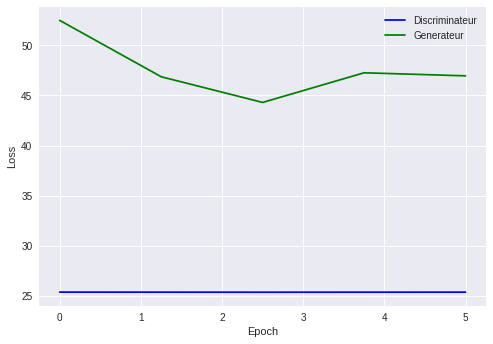

In [285]:
A=np.linspace(0,len(d_losses),len(d_losses))
plt.plot(A,d_losses,color='blue',label="Discriminateur")
plt.plot(A,g_losses, color='green',label="Generateur")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

## Entraînement CGMV

In [0]:
def train_CGMV(generator, discriminator, gan, X_train, epochs=10, batchSize=128):
  batchCount = int(nb_train_par_classe*10 / batchSize)
  print ('Epochs:', epochs)
  print ('Batch size:', batchSize)
  print ('Batches per epoch:', batchCount)
  d_losses = []
  g_losses = []
  for e in range(1, epochs+1):
    print ('-'*15, 'Epoch %d' % e, '-'*15)
    dloss=0
    gloss=0
    for _ in tqdm(range(batchCount)):
      # DISCRIMINATOR
      #generation des vecteurs de bruit
      vector_v1 = np.random.normal(0, 1, size=[batchSize, randomVectorSize])
      vector_v2 = np.random.normal(0, 1, size=[batchSize, randomVectorSize])
      vector_v3 = np.random.normal(0, 1, size=[batchSize, randomVectorSize])
      
      #choix des images
      img_x1=np.zeros((batchSize,28,28,1))
      img_x2=np.zeros((batchSize,28,28,1))
      for k in range(batchSize):
        indice1=rd.randint(0,len(X_train_2)-1)
        indice2=rd.randint(0,len(X_train_2)-1)
        img_x1[k]=X_train_2[indice1][0]
        img_x2[k]=X_train_2[indice2][0]
        
      #passage dans l'encodeur
      vector_c1=encodeur.predict(img_x1)
      vector_c2=encodeur.predict(img_x2)
      
      #passage dans le generateur
      generatedImages_1 = generator.predict([vector_c1,vector_v1])
      generatedImages_2 = generator.predict([vector_c1,vector_v2])
      generatedImages_3 = generator.predict([vector_c2,vector_v3])
      
      #entraînement du discriminateur
      indices=np.random.randint(0, len(X_train_2), size=batchSize)
      imageBatch_1 = np.zeros((batchSize,28,28,1))
      imageBatch_2 = np.zeros((batchSize,28,28,1))
      for i in range(len(indices)):
        imageBatch_1[i]=X_train_2[indices[i]][0]
        imageBatch_2[i]=X_train_2[indices[i]][1]
      XDis1=np.concatenate((imageBatch_1,generatedImages_1,img_x2))
      XDis2=np.concatenate((imageBatch_2,generatedImages_2,generatedImages_3))
      yDis = np.zeros(3*batchSize)
      yDis[:batchSize] = 0.9
      dloss += discriminator.train_on_batch([XDis1,XDis2], yDis)

      # GENERATOR
      vector_v1 = np.random.normal(0, 1, size=[batchSize, randomVectorSize])
      vector_v2 = np.random.normal(0, 1, size=[batchSize, randomVectorSize])
      vector_v3 = np.random.normal(0, 1, size=[batchSize, randomVectorSize])
      
      #choix des images
      img_x1=np.zeros((batchSize,28,28,1))
      img_x2=np.zeros((batchSize,28,28,1))
      for k in range(batchSize):
        indice1=rd.randint(0,len(X_train_2)-1)
        indice2=rd.randint(0,len(X_train_2)-1)
        img_x1[k]=X_train_2[indice1][0]
        img_x2[k]=X_train_2[indice2][0]

      yGen1 = np.ones(batchSize)
      yGen2 = np.ones(batchSize)
      discriminator.trainable = False
      gloss += gan.train_on_batch([img_x1,img_x2,vector_v1,vector_v2,vector_v3], [yGen1,yGen2])
      
    # TESTS ET EVALUATIONS
    d_losses.append(dloss)
    g_losses.append(gloss)
    print ("Losses : DISCRIMINATOR ", d_losses[-1]," GENERATOR ", g_losses[-1])
  return(d_losses,g_losses)


d_losses_C,g_losses_C=train_GAN_CGMV(generator_CGMV,discriminator_CGMV,gan_CGMV,X_train_2,10,128)

In [0]:
A=np.linspace(0,len(d_losses_C),len(d_losses_C))
plt.plot(A,d_losses_C,color='blue',label="Discriminateur")
plt.plot(A,g_losses_C, color='green',label="Generateur")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Tests

## Fonctions

In [0]:
#Affichage de 10 couples d'images generees

def plotGeneratedImages_GMV(generator, examples=10, dim=(10, 2), figsize=(15, 15)):
  vector_c = np.random.normal(0, 1, size=[examples,randomVectorSize])
  vector_v1 = np.random.normal(0, 1, size=[examples,randomVectorSize])
  vector_v2 = np.random.normal(0, 1, size=[examples,randomVectorSize])
  
  generatedImages_1 = generator.predict([vector_c,vector_v1]).reshape(examples, 28, 28)
  generatedImages_2 = generator.predict([vector_c,vector_v2]).reshape(examples, 28, 28)

  print("Couples d'images generees par le GMV :")
  plt.figure(figsize=figsize)
  for i in range(examples):
      plt.subplot(dim[0], dim[1], 2*i+1)
      plt.imshow(generatedImages_1[i], interpolation='nearest', cmap='gray_r')
      plt.axis('off')
      plt.subplot(dim[0], dim[1], 2*i+2)
      plt.imshow(generatedImages_2[i], interpolation='nearest', cmap='gray_r')
      plt.axis('off')
  plt.tight_layout()
  plt.show()
  #plt.savefig('gan_generated_image.png')
  
def plotGeneratedImages_CGMV(generator, examples=10, dim=(10, 3), figsize=(15, 15)):
  vector_v1 = np.random.normal(0, 1, size=[examples,randomVectorSize])
  vector_v2 = np.random.normal(0, 1, size=[examples,randomVectorSize])
  
  #choix des images
  img_x1=np.zeros((examples,28,28,1))
  for k in range(batchSize):
    indice1=rd.randint(0,len(X_train_2)-1)
    img_x1[k]=X_train_2[indice1][0]

  #passage dans l'encodeur
  vector_c1=encodeur.predict(img_x1)

  #passage dans le generateur
  generatedImages_1 = generator.predict([vector_c1,vector_v1]).reshape(examples, 28, 28)
  generatedImages_2 = generator.predict([vector_c1,vector_v2]).reshape(examples, 28, 28)
  
  print("image d'origine - image generee 1 - image generee 2")
  plt.figure(figsize=figsize)
  for i in range(examples):
      plt.subplot(dim[0], dim[1], 3*i+1)
      plt.imshow(img_x1[i], interpolation='nearest', cmap='gray_r')
      plt.axis('off')
      plt.subplot(dim[0], dim[1], 3*i+2)
      plt.imshow(generatedImages_1[i], interpolation='nearest', cmap='gray_r')
      plt.axis('off')
      plt.subplot(dim[0], dim[1], 3*i+3)
      plt.imshow(generatedImages_2[i], interpolation='nearest', cmap='gray_r')
      plt.axis('off')
  plt.tight_layout()
  plt.show()
  #plt.savefig('gan_generated_image.png')

In [0]:
#Test de l'accuracy du discriminateur et du generateur

def test_GMV(gan, discriminator, generator, seuil=0.45, batchSize=100):
  #generation des vecteurs de bruit
  vector_c = np.random.normal(0, 1, size=[batchSize, randomVectorSize])
  vector_v1 = np.random.normal(0, 1, size=[batchSize, randomVectorSize])
  vector_v2 = np.random.normal(0, 1, size=[batchSize, randomVectorSize])
  
  #passage dans le generateur
  generatedImages_1 = generator.predict([vector_c,vector_v1])
  generatedImages_2 = generator.predict([vector_c,vector_v2])

  #test du discriminateur
  indices=np.random.randint(0, nb_test_par_classe*10, size=batchSize)
  imageBatch_1 = np.zeros((len(indices),28,28,1))
  imageBatch_2 = np.zeros((len(indices),28,28,1))
  for i in range(len(indices)):
    imageBatch_1[i]=X_test_2[indices[i]][0]
    imageBatch_2[i]=X_test_2[indices[i]][1]
  XDis1=np.concatenate((imageBatch_1,generatedImages_1))
  XDis2=np.concatenate((imageBatch_2,generatedImages_2))
  predictions = discriminator.predict([XDis1,XDis2])
  score_d=0
  for j in range(len(predictions)):
    if j<batchSize and predictions[j]>seuil:
      score_d+=1
    elif j>= batchSize and predictions[j]<seuil:
      score_d+=1
  score_d=float(score_d)/len(predictions)
  print("Seuil = ",seuil)
  print("Score du discriminateur : "+str(score_d*100)+"%")
  
  #test du generateur
  predictions_g = gan.predict([vector_c,vector_v1,vector_v2])
  score_g=0
  #print(predictions_g)
  for j in range(len(predictions_g)):
    if predictions_g[j]>seuil:
      score_g+=1
  score_g=float(score_g)/len(predictions_g)
  print("Score du generateur : "+str(score_g*100)+"%")
  
  #Affichage d'exemples
  plt.figure(figsize=(10,10))
  for i in range(4):
      plt.subplot(8, 2, 2*i+1)
      plt.imshow(np.reshape(generatedImages_1[i],(28,28)), interpolation='nearest', cmap='gray_r')
      plt.axis('off')
      plt.subplot(8, 2, 2*i+2)
      plt.imshow(np.reshape(generatedImages_2[i],(28,28)), interpolation='nearest', cmap='gray_r')
      plt.axis('off')
  for i in range(4):
      plt.subplot(8, 2, 2*i+9)
      plt.imshow(np.reshape(imageBatch_1[i],(28,28)), interpolation='nearest', cmap='gray_r')
      plt.axis('off')
      plt.subplot(8, 2, 2*i+10)
      plt.imshow(np.reshape(imageBatch_2[i],(28,28)), interpolation='nearest', cmap='gray_r')
      plt.axis('off')
  plt.tight_layout()
  plt.show()
  print("Predictions pour les images generees : ",predictions[batchSize:batchSize+4])
  print("Predictions pour les images de MNIST : ",predictions[:4])
  
  
  
def test_CGMV(gan, discriminator, generator, seuil=0.45, batchSize=100):
  #generation des vecteurs de bruit
  vector_v1 = np.random.normal(0, 1, size=[batchSize, randomVectorSize])
  vector_v2 = np.random.normal(0, 1, size=[batchSize, randomVectorSize])
  vector_v3 = np.random.normal(0, 1, size=[batchSize, randomVectorSize])
  
  #choix des images
  img_x1=np.zeros((batchSize,28,28,1))
  img_x2=np.zeros((batchSize,28,28,1))
  for k in range(batchSize):
    indice1=rd.randint(0,len(X_train_2)-1)
    indice2=rd.randint(0,len(X_train_2)-1)
    img_x1[k]=X_train_2[indice1][0]
    img_x2[k]=X_train_2[indice2][0]

  #passage dans l'encodeur
  vector_c1=encodeur.predict(img_x1)
  vector_c2=encodeur.predict(img_x2)

  #passage dans le generateur
  generatedImages_1 = generator.predict([vector_c1,vector_v1])
  generatedImages_2 = generator.predict([vector_c1,vector_v2])
  generatedImages_3 = generator.predict([vector_c2,vector_v3])

  #test du discriminateur
  indices=np.random.randint(0, len(X_train_2), size=batchSize)
  imageBatch_1 = np.zeros((batchSize,28,28,1))
  imageBatch_2 = np.zeros((batchSize,28,28,1))
  for i in range(len(indices)):
    imageBatch_1[i]=X_train_2[indices[i]][0]
    imageBatch_2[i]=X_train_2[indices[i]][1]
  XDis1=np.concatenate((imageBatch_1,generatedImages_1,img_x2))
  XDis2=np.concatenate((imageBatch_2,generatedImages_2,generatedImages_3))
  predictions = discriminator.predict([XDis1,XDis2])
  score_d=0
  for j in range(len(predictions)):
    if j<batchSize and predictions[j]>seuil:
      score_d+=1
    elif j>= batchSize and predictions[j]<seuil:
      score_d+=1
  score_d=float(score_d)/len(predictions)
  print("Seuil = ",seuil)
  print("Score du discriminateur : "+str(score_d*100)+"%")
  
  #test du generateur
  predictions_g = gan.predict([img_x1,img_x2,vector_v1,vector_v2,vector_v3])
  score_g=0
  #print(predictions_g)
  for j in range(len(predictions_g)):
    if predictions_g[j][0]>seuil:
      score_g+=1
    if predictions_g[j][1]>seuil:
      score_g+=1
  score_g=float(score_g)/(2*len(predictions_g))
  print("Score du generateur : "+str(score_g*100)+"%")
  
  #Affichage d'exemples
  plt.figure(figsize=(10,10))
  for i in range(4):
      plt.subplot(8, 2, 2*i+1)
      plt.imshow(np.reshape(generatedImages_1[i],(28,28)), interpolation='nearest', cmap='gray_r')
      plt.axis('off')
      plt.subplot(8, 2, 2*i+2)
      plt.imshow(np.reshape(generatedImages_2[i],(28,28)), interpolation='nearest', cmap='gray_r')
      plt.axis('off')
  for i in range(4):
      plt.subplot(8, 2, 2*i+9)
      plt.imshow(np.reshape(imageBatch_1[i],(28,28)), interpolation='nearest', cmap='gray_r')
      plt.axis('off')
      plt.subplot(8, 2, 2*i+10)
      plt.imshow(np.reshape(imageBatch_2[i],(28,28)), interpolation='nearest', cmap='gray_r')
      plt.axis('off')
  plt.tight_layout()
  plt.show()
  print("Predictions pour les images generees : ",predictions[batchSize:batchSize+4])
  print("Predictions pour les images de MNIST : ",predictions[:4])
  

## Tests GMV

Couples d'images generees par le GMV :


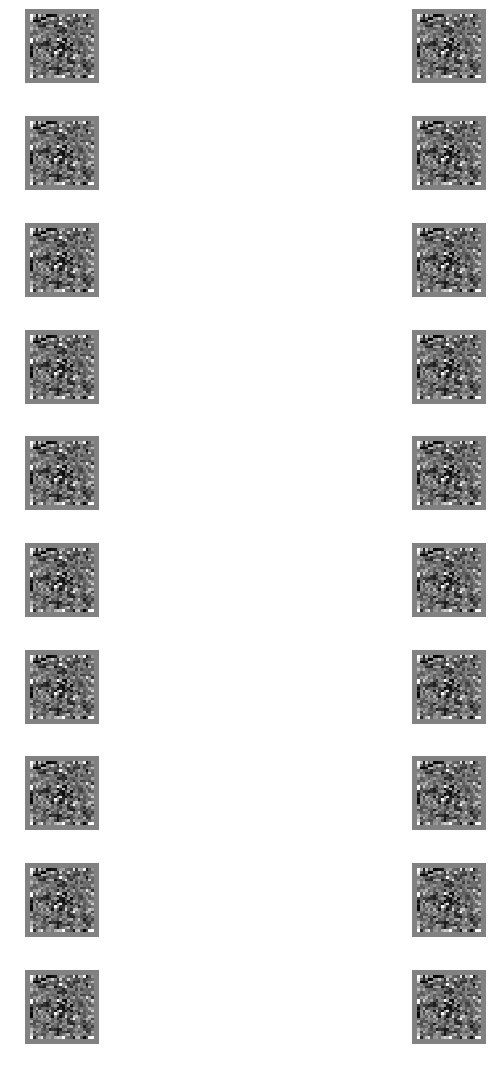

In [286]:
plotGeneratedImages_GMV(generator_GMV) #Affichage de 10 couples d'images generees

Seuil =  0.45
Score du discriminateur : 70.0%
Score du generateur : 0.0%


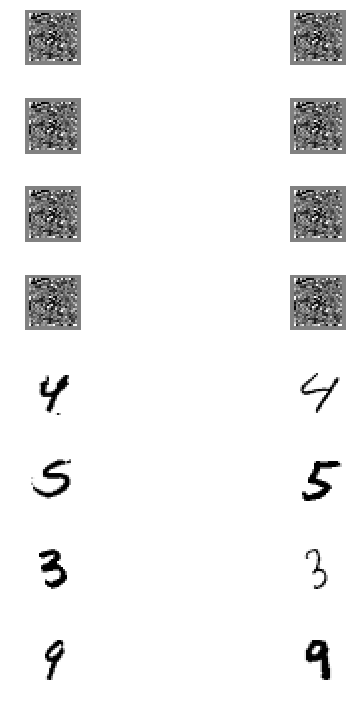

Predictions pour les images generees :  [[0.33688027]
 [0.337204  ]
 [0.33766633]
 [0.33702216]]
Predictions pour les images de MNIST :  [[0.4452882 ]
 [0.4478955 ]
 [0.44935936]
 [0.45591667]]


In [287]:
test_GMV(gan_GMV, discriminator_GMV, generator_GMV) # Calcul de l'accuracy du generateur et du discriminateur

## Tests CGMV

In [0]:
plotGeneratedImages_CGMV(generator_CGMV) #Affichage de 10 couples d'images generees

In [0]:
test_CGMV(gan_CGMV, discriminator_CGMV, generator_CGMV) # Calcul de l'accuracy du generateur et du discriminateur